<a href="https://colab.research.google.com/github/Ponranjana/CIFAR10-Pet-Classifier/blob/main/img_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 installing grad cam

In [ ]:
!pip install grad-cam


Import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import gradio as gr
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

DOWNLOADING AND PREPARING THE DATA

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 1. Cleaning instructions
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 2. Download the TRAINING set (School books)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

# 3. Download the TEST set (Exam papers) - THIS IS THE MISSING PIECE!
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

# 4. The Names of the 10 categories
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("Success! Both trainloader and testloader are ready.")

Success! Both trainloader and testloader are ready.


BUILDING THE BRAIN(MODEL)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MyFirstBrain(nn.Module):
    def __init__(self):
        super().__init__()
        # Layer 1: Looking for simple things like lines and edges
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        # Layer 2: Looking for shapes like circles or triangles
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        # The "Shrinker": Makes the picture smaller so it's easier to look at
        self.pool = nn.MaxPool2d(2, 2)

        # The "Decision Maker": Tells us if it's a cat, dog, or plane
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Pass through Layer 1 + Wash + Shrink
        x = self.pool(F.relu(self.conv1(x)))
        # Pass through Layer 2 + Wash + Shrink
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten: Turn the square picture into a single long line of numbers
        x = x.view(-1, 32 * 8 * 8)

        # Make the final guess
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the brain and send it to the computer's "fast engine" (GPU)
model = MyFirstBrain().to("cuda" if torch.cuda.is_available() else "cpu")
print("The Brain is born!")

The Brain is born!


TRAINING

In [ ]:
import torch.optim as optim

# 1. The "Teacher" (Optimizer) and the "Scoring System" (Loss)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 2. The Training Loop
print("School is starting... this might take a minute!")

for epoch in range(2): # We'll go through the whole book 2 times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get the pictures and labels
        inputs, labels = data
        inputs, labels = inputs.to("cuda"), labels.to("cuda")

        # Zero the memory from the last guess
        optimizer.zero_grad()

        # Guess, Score, and Learn
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward() # This is the "Aha!" moment where it learns from the mistake
        optimizer.step() # The brain adjusts its tiny gears

        running_loss += loss.item()
        if i % 500 == 499: # Print progress every 500 boxes
            print(f'Batch {i+1}: The brain is getting smarter...')

print("School's out! The brain is trained.")

School is starting... this might take a minute!
Batch 500: The brain is getting smarter...
Batch 1000: The brain is getting smarter...
Batch 1500: The brain is getting smarter...
Batch 500: The brain is getting smarter...
Batch 1000: The brain is getting smarter...
Batch 1500: The brain is getting smarter...
School's out! The brain is trained.


EVALUATION

In [ ]:
correct = 0
total = 0

# We don't need to learn anymore, so we tell the brain to just "think"
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to("cuda"), labels.to("cuda")

        # The brain makes its guess
        outputs = model(images)

        # We pick the highest "vote"
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the brain on the 10,000 test images: {100 * correct / total}%')

Accuracy of the brain on the 10,000 test images: 64.4%


MISCLASSIFIED IMAGES

GroundTruth:  cat   ship  ship  plane
Predicted:    cat   ship  ship  plane


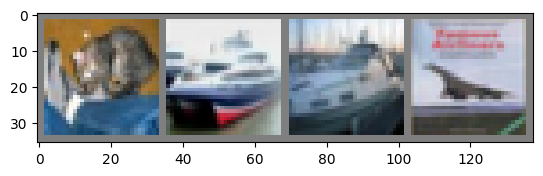

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Grab a few images from the test set
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to("cuda"), labels.to("cuda")

# 2. Ask the brain for its opinion
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# 3. Show the images and what the brain thought
def imshow(img):
    img = img / 2 + 0.5     # Un-wash the image (unnormalize)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
print('Predicted:   ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))
imshow(torchvision.utils.make_grid(images.cpu()[:4]))

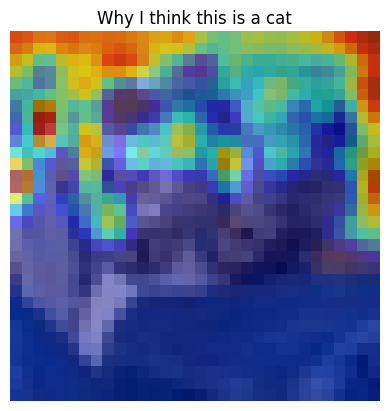

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# 1. Pick the "Detective" (Layer) we want to watch
# We use model.conv2 because it's the last part that sees shapes
target_layers = [model.conv2]

# 2. Set up the X-Ray tool
cam = GradCAM(model=model, target_layers=target_layers)

# 3. Take one image and get it ready
input_tensor = images[0:1]
rgb_img = input_tensor[0].cpu().numpy().transpose(1, 2, 0)
# Make the colors look normal for us humans
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

# 4. Generate the Heatmap
targets = [ClassifierOutputTarget(labels[0].item())]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

# 5. Paint the heatmap on top of the original picture
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.title(f"Why I think this is a {classes[labels[0].item()]}")
plt.axis('off')
plt.show()

In [ ]:
import torch

# This defines the "Garage" location
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is set to: {device}")

Device is set to: cuda


GRADIO APP

In [ ]:
import gradio as gr
import torch.nn.functional as F
from PIL import Image

def predict_image(img):
    # 1. The new way to resize: Turn the upload into a PIL image and shrink it
    img = Image.fromarray(img).resize((32, 32))

    # 2. Prep it for the brain (The "Cleaning")
    img_tensor = transforms.ToTensor()(img).unsqueeze(0).to(device)

    # 3. Let the brain guess
    with torch.no_grad():
        prediction = model(img_tensor)
        probs = F.softmax(prediction, dim=1)[0]

    # 4. Show the results
    return {classes[i]: float(probs[i]) for i in range(10)}

# 5. Build the Interface (Notice we removed 'shape=')
app = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(),
    outputs=gr.Label(num_top_classes=3),
    title="My First AI Image Classifier",
    description="I'm a student-built AI! Upload a 32x32 style image of a pet or vehicle."
)

app.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://5ad186ee6b1ba4f3ea.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/httptools_impl.py", line 416, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1138, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 107, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/error

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://5ad186ee6b1ba4f3ea.gradio.live


SAVING THE KNOWLEGE

In [ ]:
# Save the 'knowledge' to a file called student_model.pth
# We fixed the typo: state_dict() instead of state_state_dict()
torch.save(model.state_dict(), 'student_model.pth')

print("Success! Your AI brain is now saved as 'student_model.pth'.")
print("Check the folder icon 📁 on the left sidebar to see your file!")

Success! Your AI brain is now saved as 'student_model.pth'.
Check the folder icon 📁 on the left sidebar to see your file!
